In [95]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Tuple
from antea.elec import tof_functions as wvf 
from scipy import signal
from scipy.optimize import leastsq
from scipy.optimize import least_squares
%matplotlib nbagg
%reload_ext autoreload
%autoreload 2

In [56]:
# Time unit (tu) -> 100 ps
# Simulation Time Step -> 5ns (50 tu)
time_unit = 100E-12
time_step = 50 #tu
#TIME_rnd = np.add.accumulate(np.random.poisson(9,100))
#PE_rnd   = np.random.choice([1,2],100,replace=True,p=[0.95,0.05])
TIME_rnd     = np.array([ 500, 570,1000,1040,1060,1100,1110,1160,1200,1230,1300,
                         1400,1440,1460,1500,1510,1560,1600,1630,1700,1710,1750])
PE_rnd       = np.array([   1,   4,  30,  40,  25,  15,  20,  25,  30,  10,   4,   
                           25,  35,  20,  10,  40,  30,  15,  10,   5,   4,   1])

In [57]:
# Waveform generator
def wave_gen(pe_time_zs:np.array) -> Tuple[np.array,np.array]:
    
    # Constants
    q = 1.6021E-19
    #Electron charge
    SIPM_gain = 500000
    # Time unit (tu) -> 100 ps
    # Simulation Time Step -> 5ns (50 tu)
    
    spe_response,norm = wvf.apply_spe_dist(np.arange(0,20000),[10,500])
    spe_response_C = spe_response * SIPM_gain * q 
    #spe_response in Coulombs
    spe_response_A = spe_response_C / (time_unit)
    #spe_response in Amperes
    
    print("CHECK: Electrons in spe_response = %f" % (np.sum(spe_response_A)*time_unit/q/SIPM_gain))
    
    time = np.arange(0,pe_time_zs[0,-1]*time_step+len(spe_response_A))
    pe   = np.zeros(pe_time_zs[0,-1]*time_step+len(spe_response_A))
    pe[pe_time_zs[0,:]*time_step] = pe_time_zs[1,:]  
    
    # C. Romo convolution
    wave = wvf.convolve_tof(spe_response_A,pe)
    return time,wave

In [58]:
time,wave = wave_gen(np.vstack([TIME_rnd,PE_rnd]))

CHECK: Electrons in spe_response = 1.000000


# Bandwidth limit

In [59]:
# Shaping based on bandwidth guess
f_sample = (1/time_unit); # Hz
BW_guess = 25E6; # Hz
#freq_LPF = 1/(100*1E-9); # rad/sec
freq_LPF = 2*np.pi*BW_guess; # rad/sec
freq_LPFd = freq_LPF / (f_sample*np.pi); # Normalized by Nyquist Freq (half-cycles/sample)
# Filter Definitions
b, a = signal.butter(1, freq_LPFd, 'low', analog=False)
signal_out = signal.lfilter(b,a,wave)

<IPython.core.display.Javascript object>


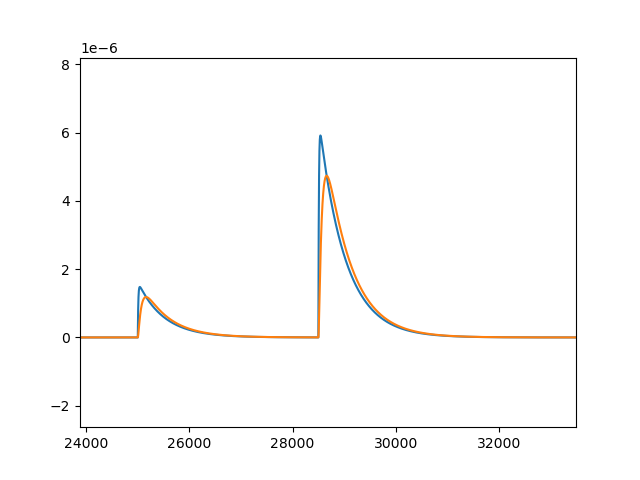

In [60]:
plt.plot(wave)
plt.plot(signal_out)

# PROPOSAL 1: Square root  domain integrator

In [106]:
class mosfet(object):
    def __init__(self,**kwargs):
        self.KPP_2n = kwargs['KPP_2n']
        self.W_L = kwargs['W_L']
        self.VTH = kwargs['VTH']
    
    def iDS(self,vGS):
        i_DS_aux = self.KPP_2n*self.W_L*(vGS-self.VTH)**2
        return i_DS_aux
    
    def vGS(self,iDS):
        v_GS_aux = np.sqrt(iDS/(self.KPP_2n*self.W_L))+self.VTH
        return v_GS_aux

class translinear_loop(object):
    # Functions are written taking into account the usage of refined MOSFET models
    # to study the effect of inversion level changes etc.
    
    def __init__(self, KPP_2n=150E-6, W_L=10, VTH=0.55):
        self.MN_1 = mosfet(KPP_2n=KPP_2n, W_L=W_L,   VTH=VTH)
        self.MN_2 = mosfet(KPP_2n=KPP_2n, W_L=W_L * 4, VTH=VTH)
    
    def VTL_mult_div(self,vGS_C,I_A,sqrt_term):
        vGS_A = self.MN_1.vGS(I_A)
        return (self.MN_1.iDS(vGS_C)+I_A)-(self.MN_2.iDS((vGS_A+vGS_C)/2.0)-sqrt_term)
    
    def geo_mean(self,I_A,I_B):
        # Translinear loop follows basic eq. vGS_o = vGS_A + vGS_B
        vGS_o = (self.MN_1.vGS(I_A) + self.MN_1.vGS(I_B))/2.0
        I_o   = self.MN_2.iDS(vGS_o)
        # Now we apply substraction of I_A and I_B currents
        I_C   = I_o - (I_A + I_B)
        return I_C
    
    def mult_div(self,I_X,I_Y,I_A):
        sqrt_term = self.geo_mean(I_X,I_Y)
        # Translinear loop follows basic eq. vGS_o = vGS_A + vGS_B
        # Adapted to feedback loop, solved with least_squares
        EFunc_Lambda = lambda vGS_C: self.VTL_mult_div( vGS_C, I_A, sqrt_term)
        
        vGS_C = least_squares(  EFunc_Lambda,
                                x0=0,
                                bounds=(0,3.3),
                                ftol=1e-10,
                                xtol=1e-10,
                                gtol=1e-15)
        
        I_C = self.MN_1.iDS(vGS_C['x'])
        
        return I_C
    

In [107]:
A=translinear_loop()
print(A.mult_div(100E-6,100E-6,50E-6))

[0.0002]
